In [132]:
#!/usr/bin/env python
import librosa 
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from librosa import display
import os
import subprocess


sr of './audio/jarman30.wav' is 22050


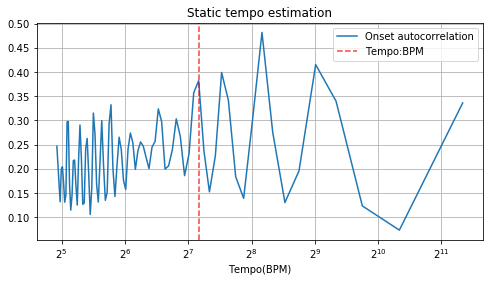

In [133]:
#source audio to process
audiofi = './audio/nommo_60.wav'
audiofi = './audio/nommoslice.wav'
audiofi = './audio/jarman.wav'
audiofi = './audio/jarman30.wav'

y,sr = librosa.load(audiofi) # load in source audio
dur = float(len(y))/sr
print 'sr of %r is %r' %(audiofi, sr) 
onset_env = librosa.onset.onset_strength(y,sr=sr) # extract onset envelope per frame
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)  # detect global tempo estimate

hop_length = 512 # define hop size
ac = librosa.autocorrelate(onset_env, 2 *sr // hop_length) #autocorrelate
freqs = librosa.tempo_frequencies(len(ac),sr=sr, hop_length=hop_length) # get tempo frequencies

# plot onset autocorrelation along with global BPM tempo estimate
plt.figure(figsize=(8,4))
plt.semilogx(freqs[1:], librosa.util.normalize(ac)[1:],
            label='Onset autocorrelation', basex=2)
plt.axvline(tempo,0,1,color='r', alpha=0.75, linestyle='--',
           label='Tempo:BPM'.format(tempo)) 
plt.xlabel('Tempo(BPM)') 
plt.grid()
plt.title('Static tempo estimation') 
plt.legend(frameon=True)
plt.axis('tight')
plt.show()
plt.close()

In [134]:
# dynamic tempo estimates
plt.figure() 
# get estimated bpm per FRAME --> dtempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                           aggregate=None)
tg = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr
                              ,hop_length=hop_length)

#librosa.display.specshow(tg, x_axis='time', y_axis='tempo')
# plt.plot(librosa.frames_to_time(np.arange(len(dtempo))),dtempo,
#         color='w', linewidth=1.5, label='Tempo Estimate') 
# plt.title('dynamic tempo estimate') 
# plt.legend(frameon=True, framealpha=0.75)
# plt.show()

In [135]:
print len(dtempo)
print len(onset_env)

431
431


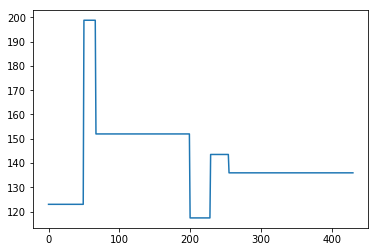

In [136]:
plt.figure() 
plt.plot(dtempo) 
plt.show()



In [137]:
def constructbeats(tempovect):
    hop_length = 512.0 
    sr = 22050.0
    
    total_num_frames = len(tempovect) # just over 1 second of frames

    frames_in_sec = sr/hop_length
    print 'size of beatframes', tempovect.shape

    tempovectinframes = tempovect/(60.0*frames_in_sec)
    beat = 0 

    beats = []
    
    for i in range(len(tempovectinframes)):
        beat += tempovectinframes[i] # accumulate beatframe until reaching 1
        if beat >= 1.0:
            beats.append(i*hop_length)
            #print 'for bpm %r, create a beat at sample number %r' %(tempovect[i],hop_length*i)
            beat = 0
        
    # return the sample numbers to place beat on top of
    return beats

size of beatframes (431,)
max beat sample number is 216064.0
y len 220500


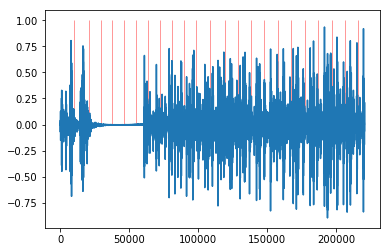

In [138]:
thebeats = constructbeats(dtempo)

print 'max beat sample number is', max(thebeats)
print 'y len', len(y)

plt.figure()
plt.vlines(thebeats, 0, 1, color='r', alpha=0.8, linewidth='0.5')
plt.plot(y)
plt.show()



In [139]:
overaudio = overlaybeats('./samples/woodblock_mono.wav', thebeats, audiofi)

len ysource 220500
sr:22050, srsource:22050
length of ysamp: 9549
window length, 230049
here


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [97]:
! soxi ./audio/nommoslice.wav


Input File     : './audio/nommoslice.wav'
Channels       : 2
Sample Rate    : 44100
Precision      : 16-bit
Duration       : 00:00:20.70 = 912759 samples = 1552.31 CDDA sectors
File Size      : 3.65M
Bit Rate       : 1.41M
Sample Encoding: 16-bit Signed Integer PCM



In [140]:
writename = os.path.splitext(os.path.basename(audiofi))[0] + '_dynbeat.wav'
print 'writing %r to file' %(writename)
librosa.output.write_wav('./beataudio/'+writename, overaudio,sr=sr)

writing 'jarman30_dynbeat.wav' to file


In [144]:
subprocesscall = 'play ./beataudio/' + writename
print subprocesscall
subprocess.call(subprocesscall, shell=True)

play ./beataudio/jarman30_dynbeat.wav


0

In [94]:
!open -a Audacity ./beataudio/nommoslice_dynbeat.wav

In [50]:
! open -a Audacity ./beataudio/dtempo.wav

In [103]:
print dur

20.6975056689


In [127]:
# function to overlay woodblock sample onto source audio from the dynamic beat tracker
def overlaybeats(samplepath, framepattern, sourcepath):
    #print framepattern
    [ysamp, sr] = librosa.load(samplepath, offset=0)
    [ysource, srsource] = librosa.load(sourcepath, offset=0, duration=dur)
    print 'len ysource', len(ysource)
    print "sr:%r, srsource:%r"%(sr,srsource)
    
    if srsource != sr:
        print 'sample rates of source and sample are not the same!'
    
    sampsz = len(ysamp)
    print 'length of ysamp:', sampsz
    sourcesz = len(ysource)
    
    window = np.array(ysource)
    window = np.concatenate((window,np.zeros(sampsz)))
    print 'window length,', len(window)
    
    print 'here'
    for i,samp in enumerate(framepattern):
        #print frame
        #print i, samp
        #print onset_amps[frame]
        #print window[frame:(frame+sampsz)]
        
        #scaled by onset amp
        #window[samp:(samp+sampsz)] = window[samp:(samp+sampsz)] + onset_amps[i]*ysamp

        #window[samp:(samp+sampsz)] *= ysamp
        window[samp:(samp+sampsz)] = window[samp:int(samp+sampsz)] + ysamp
      
    return window